In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
# Import generic libraries
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns
import scipy.io
import os, sys
import tqdm
# from scipy.optimize import curve_fit
# from pathlib import Path
# import pickle

In [3]:
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix

In [4]:
# Import local OASIS installation
sys.path.append(os.path.expanduser('~/projects/2017-kohl/OASIS'))
from oasis.functions import deconvolve
from oasis import oasisAR1, oasisAR2

/home/zenke/projects/2017-kohl/OASIS/oasis/functions.py:14: UserWarning: Could not find cvxpy. Don't worry, you can still use OASIS, just not the slower interior point methods we compared to in the papers.
  "just not the slower interior point methods we compared to in the papers.")


In [7]:
import tensortools as tt

In [8]:
# Import local tools
sys.path.append(os.path.expanduser('~/projects/2017-kohl/repo/'))
from pynalysis import utils

In [9]:
def datamatrix2tensor(data, event_times, toff_after, toff_before=0):
    """ Slices flat data matrix into trial based tensor.
    
    Expects data to be time x unit.
    
    Returns: A tuple of (list, tensor) in which the list contains the indices of valid trials (ie. the ones
    for which the time interval was valid) and the tensor contains the data in format trial x time x unit.
    """
    trials = []
    indices = [] 
    nb_frames = data.shape[0]
    for i,ev in enumerate(event_times):
        fr = int(ev)
        if fr<toff_before or fr>nb_frames-toff_after: continue
        s = data[fr-toff_before:fr+toff_after]
        trials.append(s)
        indices.append(i)
    return indices, np.array(trials)

In [10]:
def load_and_preprocess(area):
    """ Extract and preprocess data from HDF5 file. """
    
    elements = utils.get_hdf5group_keys(area)
    
    planes = []
    for i in range(2):
        planekey = "plane%i"%(i+1)
        if planekey in area.keys():
            planes.append(area[planekey])
    
    sessbehav=area['session_behaviour']
    print(utils.get_hdf5group_keys(sessbehav))
    
    # Extract frame rate from struct
    frate = area['plane1/fRate'][0,0]
    # print("Frame rate %f"%frate)
    
    fluo = planes[0]['fluoresence_corrected']
    time = np.arange(len(fluo))*1.0/frate
    
    # Extract event timing
#     motor_events = ['motor_start', 'motor_back', 'motor_atWhisk']
#     event_fields = []
#     event_fields.extend(motor_events)
#     event_fields.extend(['velocity', 'stim_position'])
    event_fields = utils.get_hdf5group_keys(sessbehav)
    # event_fields = ['motor_start']

    events = {}
    for f in event_fields:
        events[f] = np.array(sessbehav[f]).ravel()
                
    # tau_d = 270e-3 # GCAMP6M
    # tau_d = 142e-3 # GCAMP6F
    tau_d = 550e-3 # GCAMP6S

    ginit = (np.exp(-1.0/(frate*tau_d)),)
    # ginit = (None,)

    plane_data = []
    for plane in planes:
        # Get raw fluoresence
        fluo = np.array(plane['fluoresence_corrected'], dtype=np.float32)
    
        # Extrac cell positions
        tmp = []
        for pos in plane['position']:
            tmp.append(pos)
        positions_plane = np.array(tmp).T

        # Run OASIS on each fluorescence trace   
        traces = []
        spike_trains = []
        # TODO
        ret_values = []
        for idx in range(fluo.shape[1]):
            y = np.array(fluo[:,idx],dtype=float)
            c, s, b, g, lam = r = deconvolve(y, g=ginit, penalty=1)
            if np.isnan(c.sum()):
                traces.append(np.zeros(c.shape))
                spike_trains.append(np.zeros(s.shape))
                ret_values.append(r)
            else:
                traces.append(c)
                spike_trains.append(s)
                ret_values.append(r)
        traces = np.array(traces, dtype=np.float32).T
        spike_trains = np.array(spike_trains, dtype=np.float32).T
        
        plane_data.append( dict(fluo=fluo, spikes=spike_trains, traces=traces, pos=pos) )
    
    return time, events, plane_data, frate

In [11]:
def process_hdf_path(hdf5handle, hdf5path, frames_before=15, frames_after=75):
    print("Processing %s -- %s"%(stringid,hdf5path))
    try:
        data = load_and_preprocess(hdf5handle.get(hdf5path))
    except KeyError:
        print("KeyError when preprocessing %s, probably some missing event type?"%hdf5path)
        return
    except TypeError: 
        print("Warning! Could not load %s"%expspecifier)
        return

    
    times, events, plane_data, frate = data

    trigger_times = events['motor_atWhisk']
    # extract velocity
    velocity = events['velocity'].ravel()
    if velocity.max()!=np.abs(velocity).max():
        velocity *= -1
    velocity /= velocity.max()
    valid_indices, trial_velocity = datamatrix2tensor(velocity, 
                          trigger_times, 
                          toff_before=frames_before, 
                          toff_after=frames_after)
    mean_trial_velocity = trial_velocity.mean(1)

    for plane in plane_data:
        # Create data tensor from denoised traces for all trials
        valid_indices, datatensor = datamatrix2tensor(plane["traces"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["datatensor"] = datatensor
        plane["valid_trials"] = valid_indices

        _, fluotensor = datamatrix2tensor(plane["fluo"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["fluotensor"] = fluotensor

        _, spiketensor = datamatrix2tensor(plane["spikes"], 
                                                      trigger_times, 
                                                      toff_before=frames_before,                                               
                                                      toff_after=frames_after)

        plane["spiketensor"] = spiketensor

        tmp = (datatensor-datatensor.min(0))/(datatensor.std(0)+1.0e-2)
        plane["standardized_trial_data"] = tmp.reshape((tmp.shape[0],-1))


    # extract labels
#     raw_labels = events['stim_position'].ravel()[valid_indices]
#     new_labels = 1*raw_labels
#     for i,l in enumerate(np.unique(raw_labels)):
#         new_labels[new_labels==l] = i
#     labels = new_labels

    result = dict(filename=filename,
                stringid=stringid,
                hdf5path=hdf5path,
                times=times, 
                frate=frate,
                events=events, 
                planes=plane_data, 
                velocity=velocity,
                mean_trial_velocity=mean_trial_velocity,
                # labels=labels,
                )
    
    return result

In [12]:
def get_data_packs(hdf5handle):
    
    data_packs = []
    for day in hdf5handle["imaging"]: 
        for area in dat["imaging"][day]: 
            expspecifier = "%s/%s"%(day,area)
            hdf5path="imaging/%s"%expspecifier
            res = process_hdf_path(hdf5handle, hdf5path)
            if res is not None:
                data_packs.append(res)
        
    return data_packs

In [13]:
# Load data from struct file
stringid="CTBD1.3g"
filename = os.path.expanduser('~//data/kohl/structures/%s.mat'%stringid)
dat = utils.load_mat_file(filename)
packs = get_data_packs(dat)

Processing CTBD1.3g -- imaging/date_2018_06_13/area1
['ID', 'TTLs', 'area', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
Processing CTBD1.3g -- imaging/date_2018_06_13/area2
['ID', 'TTLs', 'area', 'area1', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
Processing CTBD1.3g -- imaging/date_2018_06_22/area1
['ID', 'TTLs', 'area', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
Processing CTBD1.3g -- imaging/date_2018_06_22/area2
['ID', 'TTLs', 'area', 'area1', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'stim_speed', 'task', 'velocity']
Processing CTBD1.3g -- imaging/date_2018_06_22/area3
['ID', 'TTLs', 'area', 'area1', 'area2', 'date', 'motor_atOrigin', 'motor_atWhisk', 'motor_back', 'motor_start', 'stim_position', 'st

In [11]:
def plot_event(dp,event_name,y_offset=0,**kwargs):
    x = dp["events"][event_name]/dp["frate"]
    y = y_offset*np.ones(len(x))
    plt.scatter(x,y,label=event_name,**kwargs)

In [12]:
def bin_data(data,bs=5):
    """ Bin data along first axis. 
    
    # Args
    data - The data array
    bs - The bin size 
    
    # Returns
    Array with same dimensions as data exept the one which was binned.
    """
    shape = list(data.shape)
    shape[0] = shape[0]//bs 
    binned = np.zeros(shape)
    for b in range(shape[0]):
        binned[b] = data[b*bs:(b+1)*bs].sum(0)
    return binned

def bin_events(dp,event_name,nb_bins=100,bs=5):
    events = np.array(dp["events"][event_name],dtype=int)//bs
    binned = np.zeros(nb_bins)
    for e in events:
        binned[e] += 1
    return binned

In [14]:
def get_trial_labels(dp, trial_times):
    trial_behavior = np.zeros((len(trial_times),5))

    # prep lists
    label_event_names = [ "correct", "missed", "too_soon", "correct_rejection", "false_positive" ]
    evt_lists = [ list(np.array(dp["events"][l], dtype=int)) for l in label_event_names ]
    # print(evt_lists)

    # print(1/0)
    trial_labels = []
    for t in trial_times:
        e = -1
        m = 10000
        for i,lst in enumerate(evt_lists):

            while len(lst) and t>lst[0]: 
                lst.pop(0)

            if len(lst):
                d = lst[0]-t    
                if m>d:
                    m = d
                    e = i

        trial_labels.append(e)
    return np.array(trial_labels)


# Tensor decomposition

IndexError: list index out of range

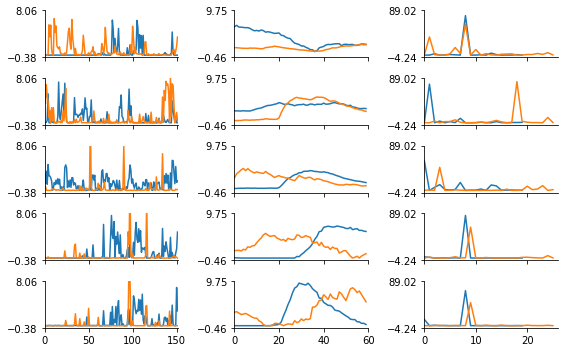

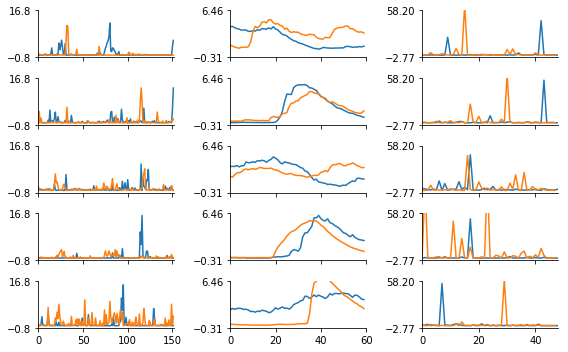

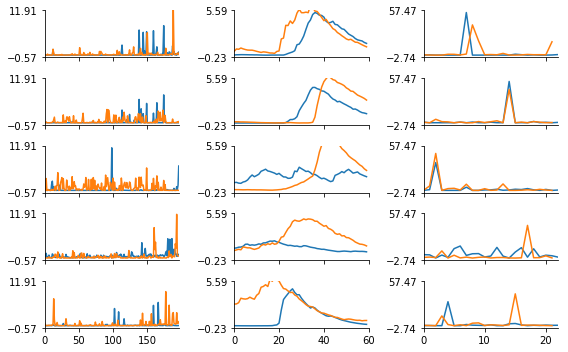

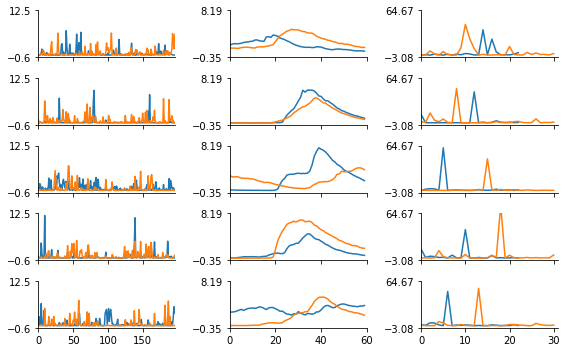

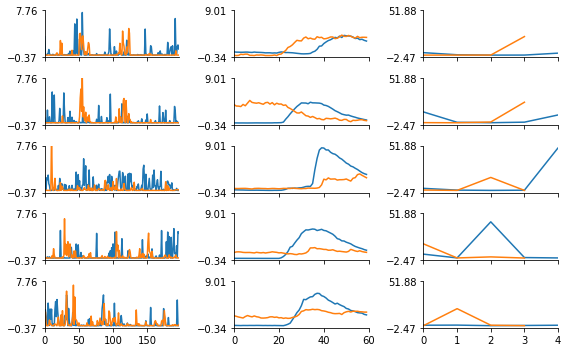

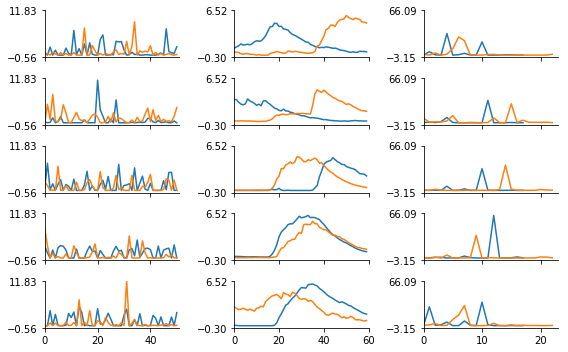

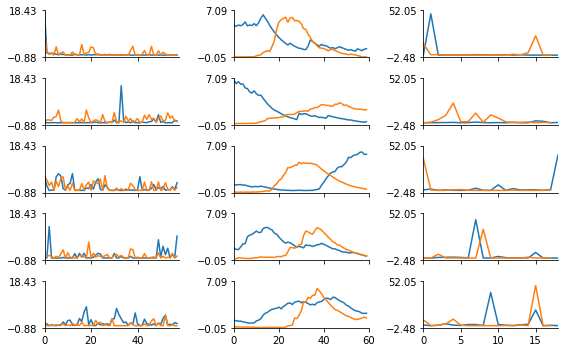

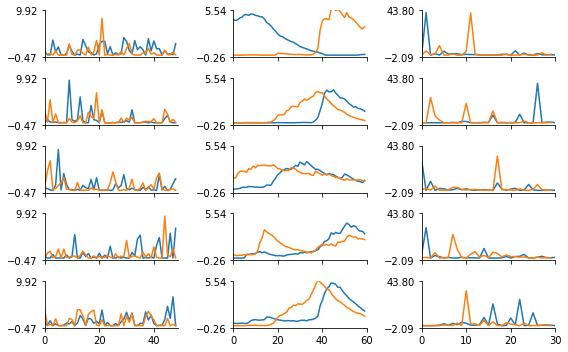

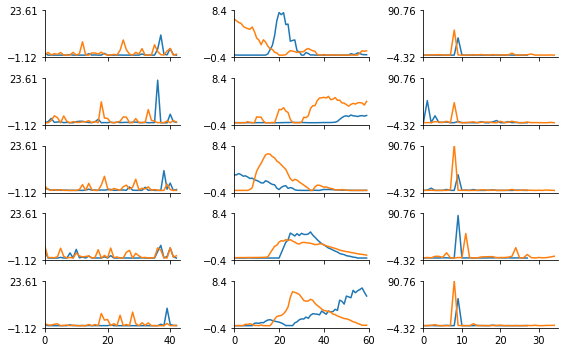

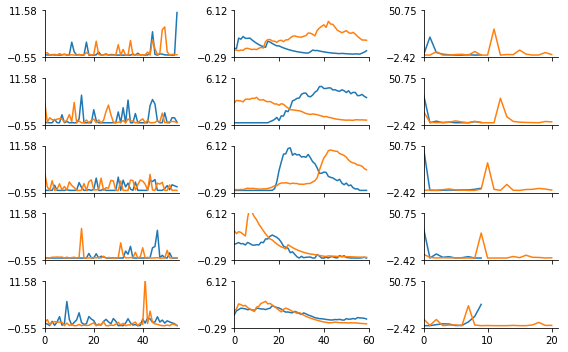

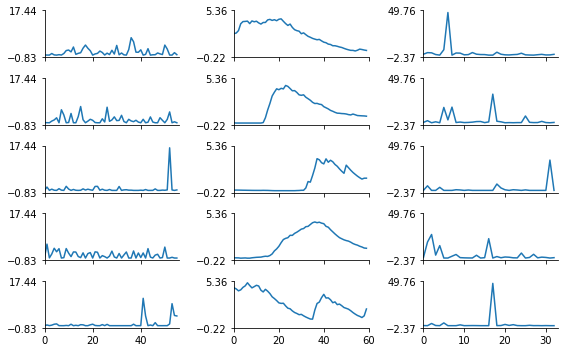

In [229]:
for k,dp in enumerate(packs):
    for pl in range(2):
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval

        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_atWhisk"], dtype=int)

        # chop up data
        duration = np.min((60,max_dur))
        off = -20
        raw = np.array(dp["planes"][pl]["traces"])
        data = []
        labels = []
        for i,t in enumerate(trial_times):
            if t+duration+off>len(raw) or t+off<0: continue
            # tmp = raw[t+off:t+duration+off].mean(axis=0)
            tmp = raw[t+off:t+off+duration]
            # tmp = raw[t:t+duration].ravel()
            data.append(tmp)
            # labels.append(all_labels[i])
        data = np.array(data)

        U = tt.ncp_bcd(data, rank=5, verbose=False)
        if pl==0:
            fig,_,_ = tt.plot_factors(U.factors)
        else:
            tt.plot_factors(U.factors, fig=fig)
        plt.savefig("plots/factors%i.png"%k)

In [488]:
from sklearn.cluster import KMeans

responses = []
for k,dp in enumerate(packs[-6:]):
    for pl in range(len(dp["planes"])):
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval

        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_start"], dtype=int)

        # chop up data
        duration = np.min((90,max_dur))
        off = -20
        raw = np.array(dp["planes"][pl]["traces"])
        data = []
        labels = []
        for i,t in enumerate(trial_times):
            if t+duration+off>len(raw) or t+off<0: continue
            tmp = raw[t+off:t+off+duration]
            data.append(tmp)
            # labels.append(all_labels[i])
        data = np.array(data).mean(0)
        data = (data-data.min(0))/(50.0+data.max(0)-data.min(0))
        # data = (data-data.min(0))/(1.0e-3+data.max(0)-data.min(0))
        print(data.shape)
        responses.append(data)
        
        
responses = np.concatenate(responses,axis=1).T

(90, 18)
(90, 23)
(90, 34)
(90, 18)
(90, 42)
(90, 30)
(90, 28)
(90, 35)
(90, 10)
(90, 21)
(90, 33)


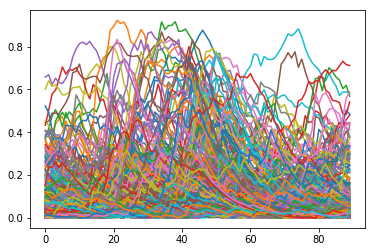

In [470]:
plt.plot(responses.T)

In [471]:
kmeans = KMeans(n_clusters=7)
kmeans.fit(responses)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [472]:
kmeans.cluster_centers_.shape

(7, 90)

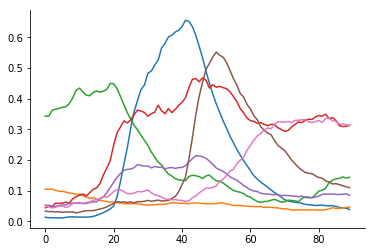

In [473]:
plt.plot(kmeans.cluster_centers_.T)
sns.despine()

In [474]:
pred=kmeans.predict(responses)

(array([ 24., 119.,   0.,  23.,   0.,  13.,  65.,   0.,  25.,  23.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

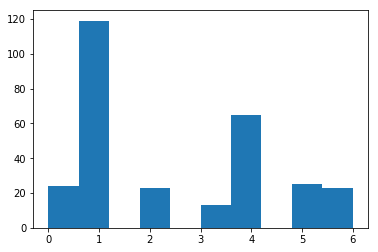

In [475]:
plt.hist(pred)

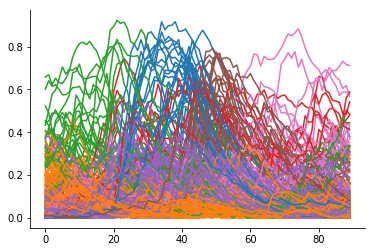

In [476]:
colz=sns.color_palette()
for r,c in zip(responses,pred):
    plt.plot(r,color=colz[c])
sns.despine()

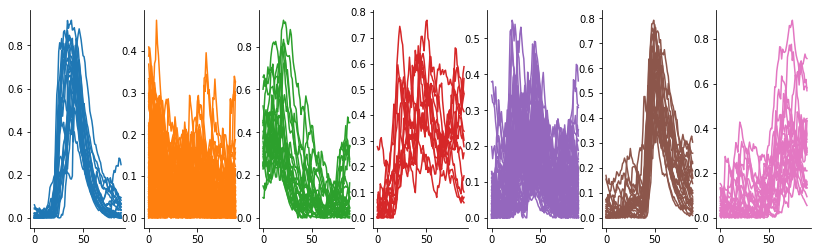

In [489]:
colz=sns.color_palette()
gs = GridSpec(1,kmeans.n_clusters)
fig=plt.figure(figsize=(14,4))
for k,p in enumerate(np.unique(pred)):
    plt.subplot(gs[k])
    for r in responses[pred==p]:
        plt.plot(r,color=colz[p])
sns.despine()

IndexError: list index out of range

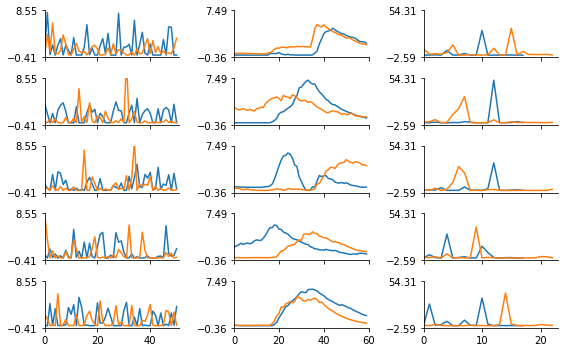

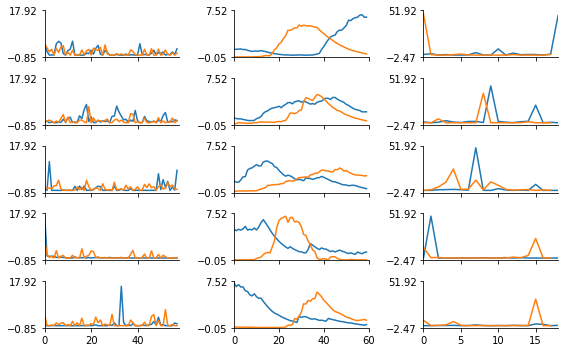

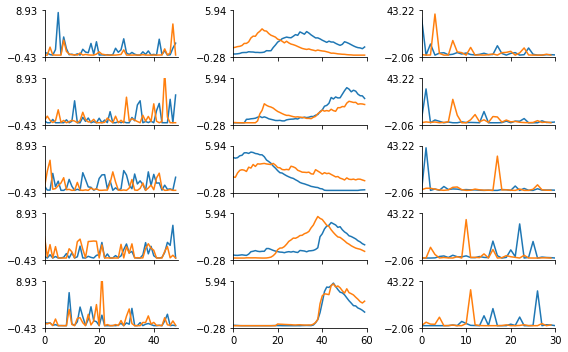

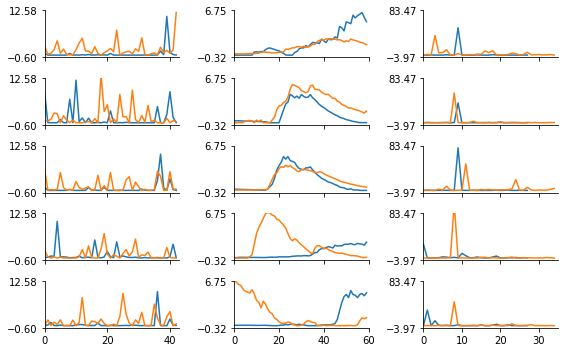

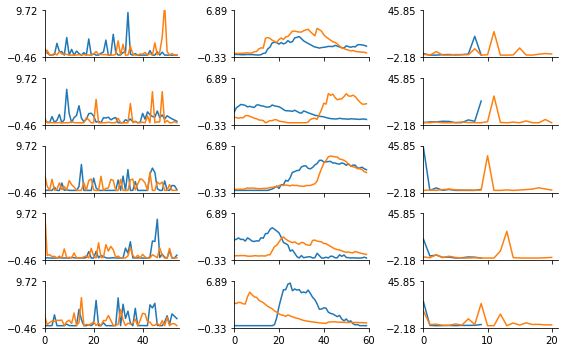

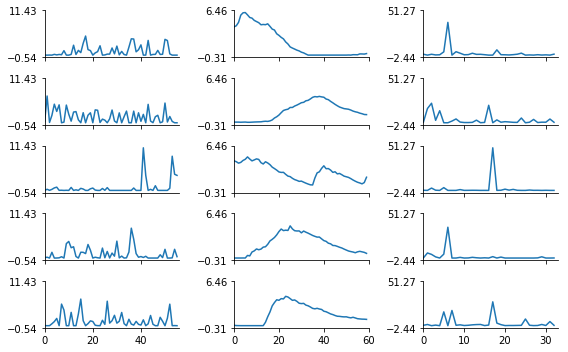

In [401]:
for k,dp in enumerate(packs[-6:]):
    for pl in range(2):
        max_dur = np.min(np.diff(np.array(dp["events"]["motor_start"], dtype=int))) # shortest inter-trial-interval

        trigger_event_name = "motor_start"
        trial_times = np.array(dp["events"]["motor_atWhisk"], dtype=int)

        # chop up data
        duration = np.min((60,max_dur))
        off = -20
        raw = np.array(dp["planes"][pl]["traces"])
        data = []
        labels = []
        for i,t in enumerate(trial_times):
            if t+duration+off>len(raw) or t+off<0: continue
            # tmp = raw[t+off:t+duration+off].mean(axis=0)
            tmp = raw[t+off:t+off+duration]
            # tmp = raw[t:t+duration].ravel()
            data.append(tmp)
            # labels.append(all_labels[i])
        data = np.array(data)

        U = tt.ncp_bcd(data, rank=5, verbose=False)
        if pl==0:
            fig,_,_ = tt.plot_factors(U.factors)
        else:
            tt.plot_factors(U.factors, fig=fig)
        plt.savefig("plots/factors%i.png"%k)

In [212]:
data.shape

(55, 60, 21)

In [213]:

# tt.plot_factors(V.factors, fig=fig)

In [195]:
data.shape

(56, 60, 33)

In [196]:
U.factors.shape

(56, 60, 33)

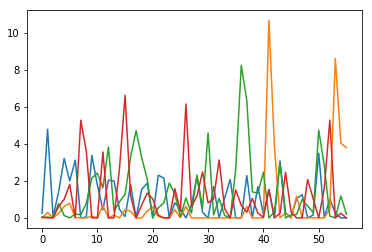

In [197]:
plt.plot(U.factors[0])

In [169]:
U.factors.factors[0].shape

(56, 4)